### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import glob
import os
import random
import pathlib

import pandas as pd
import torch
from Bio.PDB.Polypeptide import index_to_one
from collections import OrderedDict
from torch.utils.data import DataLoader, Dataset
from collections import defaultdict
from scipy.stats import pearsonr, spearmanr

from cavity_model import (
    CavityModel,
    ResidueEnvironment,
    ResidueEnvironmentsDataset,
)
import helpers
from typing import Optional, List
from visualization import scatter_pred_vs_true, plot_validation_performance
import pickle

import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", None)
import seaborn as sns

%load_ext nb_black

<IPython.core.display.Javascript object>

### Global variables

In [2]:
# Main parameters
WARM_START: Optional[List[str]] = [
    "cavity_models/repeat_00_model_epoch_01.pt",
    "cavity_models/repeat_01_model_epoch_02.pt",
    "cavity_models/repeat_02_model_epoch_01.pt",
    "cavity_models/repeat_03_model_epoch_02.pt",
    "cavity_models/repeat_04_model_epoch_02.pt",
    "cavity_models/repeat_05_model_epoch_02.pt",
]
DEVICE: str = "cuda"  # "cpu" or "cuda"
TRAIN_VAL_SPLIT: float = 0.9
BATCH_SIZE: int = 100
SHUFFLE_PDBS: bool = True
LEARNING_RATE: float = 2e-4
EPOCHS: int = 6
PATIENCE_CUTOFF: int = 0
EPS: float = 1e-9
N_MODEL_REPEATS = 6

# Parameters for simulation stride
STRIDE_FRAGMENTS: int = 2
STRIDE_MD: int = 4

# Parameters specific to downstream model
BATCH_SIZE_DDG: int = 40
SHUFFLE_DDG: bool = True
LEARNING_RATE_DDG: float = 1e-3
EPOCHS_DDG: int = 200

# Mapping between data keys and titles/colors for plots
dataset_name_mapping = {
    "dms": "DMS",
    "guerois": "Guerois",
    "protein_g": "Protein G",
    "symmetric_direct": "Symmetric (Direct)",
    "symmetric_inverse": "Symmetric (Inverse)",
}

dataset_color_mapping = {
    "dms": "steelblue",
    "guerois": "firebrick",
    "protein_g": "forestgreen",
    "symmetric_direct": "olive",
    "symmetric_inverse": "olive",
}

<IPython.core.display.Javascript object>

# Cavity Model

### Train

In [3]:
if WARM_START is None:
    # Create directory for model files
    models_dirpath = "cavity_models/"
    if not os.path.exists(models_dirpath):
        os.mkdir(models_dirpath)

    best_model_paths = []
    for i in range(N_MODEL_REPEATS):
        print(f"Repeat: {i:02d}")

        # Parse data
        parsed_pdb_filenames = sorted(glob.glob("data/pdbs/parsed/*coord*"))
        if SHUFFLE_PDBS:
            random.shuffle(parsed_pdb_filenames)
        (
            dataloader_train,
            dataset_train,
            dataloader_val,
            dataset_val,
        ) = helpers.train_val_split(
            parsed_pdb_filenames, TRAIN_VAL_SPLIT, DEVICE, BATCH_SIZE
        )

        # Define model
        cavity_model_net = CavityModel(DEVICE).to(DEVICE)
        loss_function = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(cavity_model_net.parameters(), lr=LEARNING_RATE)

        model_prefix = f"repeat_{i:02d}"
        # Train loop
        best_model_path = helpers.train_loop(
            dataloader_train,
            dataloader_val,
            cavity_model_net,
            loss_function,
            optimizer,
            model_prefix,
            EPOCHS,
            PATIENCE_CUTOFF,
        )

        best_model_paths.append(best_model_path)
else:
    print(f"Warm start: {WARM_START}")

Warm start: ['cavity_models/repeat_00_model_epoch_01.pt', 'cavity_models/repeat_01_model_epoch_02.pt', 'cavity_models/repeat_02_model_epoch_01.pt', 'cavity_models/repeat_03_model_epoch_02.pt', 'cavity_models/repeat_04_model_epoch_02.pt', 'cavity_models/repeat_05_model_epoch_02.pt']


<IPython.core.display.Javascript object>

# Load stability data, structural data and cavity model(s)

### Load structural data for ddG data sets

In [4]:
# Create temporary residue environment datasets as dicts to more easily match ddG data
parsed_pdbs_wildcards = {
    "dms": "data/data_dms/pdbs_parsed/*coord*",
    "protein_g": "data/data_protein_g/pdbs_parsed/*coord*",
    "guerois": "data/data_guerois/pdbs_parsed/*coord*",
    "symmetric": "data/data_symmetric/pdbs_parsed/*coord*",
}

resenv_datasets_look_up = {}
for dataset_key, pdbs_wildcard in parsed_pdbs_wildcards.items():
    parsed_pdb_filenames = sorted(glob.glob(pdbs_wildcard))
    dataset = ResidueEnvironmentsDataset(parsed_pdb_filenames, transformer=None)
    dataset_look_up = {}
    for resenv in dataset:
        key = (
            f"{resenv.pdb_id}{resenv.chain_id}_{resenv.pdb_residue_number}"
            f"{index_to_one(resenv.restype_index)}"
        )
        dataset_look_up[key] = resenv
    resenv_datasets_look_up[dataset_key] = dataset_look_up

<IPython.core.display.Javascript object>

### Load ddG data sets

In [5]:
ddg_data_dict = OrderedDict()
ddg_data_dict = {
    "dms": pd.read_csv("data/data_dms/ddgs_parsed.csv"),
    "protein_g": pd.read_csv("data/data_protein_g/ddgs_parsed.csv"),
    "guerois": pd.read_csv("data/data_guerois/ddgs_parsed.csv"),
    "symmetric_direct": pd.read_csv("data/data_symmetric/ddgs_parsed_direct.csv"),
    "symmetric_inverse": pd.read_csv("data/data_symmetric/ddgs_parsed_inverse.csv"),
}
# Load the residue environments to the dataframes
helpers.populate_dfs_with_resenvs(ddg_data_dict, resenv_datasets_look_up)

Dropping data points where residue is not defined in structure or due to missing parsed pdb file
dropped 1187 / 8096 data points from dataset dms
dropped    0 /  907 data points from dataset protein_g
dropped    0 /  911 data points from dataset guerois
dropped    0 /  342 data points from dataset symmetric_direct
dropped    0 /  342 data points from dataset symmetric_inverse


<IPython.core.display.Javascript object>

### Load cavity models

In [6]:
# Load best performing cavity model from previos training
if WARM_START is not None:
    best_model_paths = WARM_START

cavity_model_infer_nets = []
for best_path in best_model_paths:
    cavity_model_infer_net = CavityModel(DEVICE).to(DEVICE)
    cavity_model_infer_net.load_state_dict(torch.load(best_path))
    _ = cavity_model_infer_net.eval()
    cavity_model_infer_nets.append(cavity_model_infer_net)

<IPython.core.display.Javascript object>

# Process data and infer amino acids likelihoods

In [7]:
# Setting 1: Static setting
if not os.path.exists("processed_data_frames.pickle"):
    helpers.populate_dfs_with_nlls_and_nlfs(
        ddg_data_dict, cavity_model_infer_nets, DEVICE, BATCH_SIZE, EPS
    )

<IPython.core.display.Javascript object>

In [8]:
# Setting 2: WT Structural ensemble
if not os.path.exists("processed_data_frames.pickle"):
    # Infer NLLs for WT and MT and add to columns `wt_nll_md` and `mt_nll_md`
    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "protein_g",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=True,
    )
    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "guerois",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=False,  # Maybe fix the bug with NPT ensemble
        use_residue_number_map=True,
    )
    helpers.infer_molecular_dynamics_nlls(
        ddg_data_dict,
        "dms",
        DEVICE,
        EPS,
        cavity_model_infer_nets,
        stride=STRIDE_MD,
        is_npt_ensemble=True,
        use_residue_number_map=False,
    )

<IPython.core.display.Javascript object>

In [9]:
# Setting 3: Variant structures
if not os.path.exists("processed_data_frames.pickle"):
    helpers.get_predictions_both_structures(ddg_data_dict, len(cavity_model_infer_nets))

<IPython.core.display.Javascript object>

In [10]:
# Setting 4: Modelling the unfolded state
if not os.path.exists("processed_data_frames.pickle"):
    for data_set in ["protein_g", "dms", "guerois"]:
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_nets,
            DEVICE,
            EPS,
            is_wt=True,
            stride=STRIDE_FRAGMENTS,
        )
        helpers.infer_probabilities_for_center_residues(
            ddg_data_dict,
            data_set,
            cavity_model_infer_nets,
            DEVICE,
            EPS,
            is_wt=False,
            stride=STRIDE_FRAGMENTS,
        )

        helpers.add_ddg_preds_with_unfolded_state(
            ddg_data_dict, data_set, len(cavity_model_infer_nets)
        )

    # Calculate DDgs
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "protein_g", len(cavity_model_infer_nets)
    )
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "guerois", len(cavity_model_infer_nets)
    )
    helpers.add_ddg_preds_with_md_simulations(
        ddg_data_dict, "dms", len(cavity_model_infer_nets)
    )

<IPython.core.display.Javascript object>

### Cache processed data

In [11]:
if not os.path.exists("processed_data_frames.pickle"):
    with open("processed_data_frames.pickle", "wb") as handle:
        pickle.dump(ddg_data_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

<IPython.core.display.Javascript object>

### Load processed data

In [12]:
with open("processed_data_frames.pickle", "rb") as handle:
    ddg_data_dict = pickle.load(handle)

<IPython.core.display.Javascript object>

# Figures in  paper

In [13]:
def style_barplot_vertical(ax, legend_y, ncols=2):
    sns.despine(left=True, bottom=True, right=True)
    g.set(xlabel=None)
    g.get_legend().set_title(None)
    h,l = ax.get_legend_handles_labels()
    ax.legend_.remove()
    ax.legend(h,l, ncol=ncols, frameon=False, loc='upper right', bbox_to_anchor=(0.925,legend_y)) 
    ax.axhline(y=0, color='black')


def style_barplot(ax, legend_y, ticks_above=False, ncols=2):
    sns.despine(left=True, bottom=True, right=True)
    g.set(ylabel=None)
    g.get_legend().set_title(None)
    h,l = ax.get_legend_handles_labels()
    ax.legend_.remove()
    if ticks_above:
        ax.xaxis.set_label_position("top")
        ax.xaxis.labelpad=10 
        ax.tick_params(axis='x', which='major', labelbottom = False, bottom=False, top = False, labeltop=True, pad=-5)
        fig.legend(h,l, ncol=ncols, frameon=False, loc='lower right', bbox_to_anchor=(0.925,legend_y)) 
    else:
        ax.tick_params(axis='x', which='major', pad=-2)
        fig.legend(h,l, ncol=ncols, frameon=False, loc='lower right', bbox_to_anchor=(0.925,legend_y)) 

    ax.axvline(x=0, color='black')
    ax.set_xlim([0,0.79])


<IPython.core.display.Javascript object>

### Figure 3a

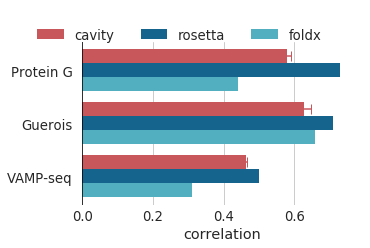

<IPython.core.display.Javascript object>

In [14]:
# Figure 3a
ULTRA_VANILLA_RS = defaultdict(list)
for data_key in [
    "protein_g",
    "guerois",
    "dms",
]:
    ddg_col = "ddg"
    for i in range(len(cavity_model_infer_nets)):
        ddg_pred_col = f"ddg_pred_ultra_vanilla_{i}"

        x = ddg_data_dict[data_key][ddg_col]
        y = ddg_data_dict[data_key][ddg_pred_col]
        x_ = [
            val[0] for val in zip(x, y) if not np.isnan(val[1]) and not np.isnan(val[0])
        ]
        y_ = [
            val[1] for val in zip(x, y) if not np.isnan(val[1]) and not np.isnan(val[0])
        ]
        pearsons_correlation = pearsonr(x_, y_)[0]
        ULTRA_VANILLA_RS[data_key].append(pearsons_correlation)


labels = ["Protein G", "Guerois", "VAMP-seq"]
cavity_correlations = [
    np.mean(ULTRA_VANILLA_RS["protein_g"]),
    np.mean(ULTRA_VANILLA_RS["guerois"]),
    np.mean(ULTRA_VANILLA_RS["dms"]),
]
cavity_stds = [
    np.std(ULTRA_VANILLA_RS["protein_g"]),
    np.std(ULTRA_VANILLA_RS["guerois"]),
    np.std(ULTRA_VANILLA_RS["dms"]),
]
rosetta_correlations = [0.73, 0.71, 0.5]
foldx_correlations = [0.44, 0.66, 0.31]
data = pd.DataFrame(
    {
        "data_set": labels * 3,
        "correlations": cavity_correlations + rosetta_correlations + foldx_correlations,
        "std": cavity_stds + [np.nan] * 6,
        "type": ["cavity"] * 3 + ["rosetta"] * 3 + ["foldx"] * 3,
    }
)

colors = ['#DB444B', '#006BA2', '#3EBCD2', '#379A8B', '#EBB434', '#B4BA39', '#9A607F', '#D1B07C']
saturation = 0.75

sns.set(font_scale = 1.2)
sns.set_palette(sns.color_palette(colors))
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(5,3))
g = sns.barplot(data=data, y='data_set', x='correlations', hue='type', ci='std', ax=ax, edgecolor='black',linewidth=0, saturation=saturation)
mask = data["std"].notna().to_numpy()
y_coords = np.array([p.get_y() + 0.5*p.get_height() for p in ax.patches])[mask]
x_coords = np.array([p.get_width() for p in ax.patches])[mask]
ax.errorbar(x=x_coords, y=y_coords, xerr=data["std"][mask], color=sns.desaturate(sns.color_palette()[0], saturation), fmt="none", capsize=5)
g.set_xlabel("correlation")
style_barplot(ax=ax, legend_y=0.9, ncols=3, ticks_above=False)



### Figure 3b

In [15]:
VANILLA_MD_RS = defaultdict(list)
for i in range(len(cavity_model_infer_nets)):
    ddg_col = "ddg"
    for data_set in ["protein_g", "guerois", "dms"]:
        x = ddg_data_dict[data_set]["ddg"]
        y = ddg_data_dict[data_set][f"ddg_pred_md_no_ds_all_{i}"]

        x_ = [
            val[0] for val in zip(x, y) if not np.isnan(val[1]) and not np.isnan(val[0])
        ]
        y_ = [
            val[1] for val in zip(x, y) if not np.isnan(val[1]) and not np.isnan(val[0])
        ]
        pearsons_correlation = pearsonr(x_, y_)[0]

        VANILLA_MD_RS[data_set].append(pearsons_correlation)

<IPython.core.display.Javascript object>

In [16]:
labels = ["Protein G", "Guerois", "VAMP-seq"]

cavity_correlations = [
    np.mean(ULTRA_VANILLA_RS["protein_g"]),
    np.mean(ULTRA_VANILLA_RS["guerois"]),
    np.mean(ULTRA_VANILLA_RS["dms"]),
]
cavity_md_correlations = [
    np.mean(VANILLA_MD_RS["protein_g"]),
    np.mean(VANILLA_MD_RS["guerois"]),
    np.mean(VANILLA_MD_RS["dms"]),
]

cavity_stds = [
    np.std(ULTRA_VANILLA_RS["protein_g"]),
    np.std(ULTRA_VANILLA_RS["guerois"]),
    np.std(ULTRA_VANILLA_RS["dms"]),
]
cavity_md_stds = [
    np.std(VANILLA_MD_RS["protein_g"]),
    np.std(VANILLA_MD_RS["guerois"]),
    np.std(VANILLA_MD_RS["dms"]),
]

data = pd.DataFrame(
    {
        "data_set": labels,
        "cavity_vanilla": cavity_correlations,
        "cavity_vanilla_stds": cavity_stds,
        "cavity_vanilla_md": cavity_md_correlations,
        "cavity_vanilla_md_stds": cavity_md_stds,
    }
)
data = pd.concat([data[['data_set', 'cavity_vanilla', 'cavity_vanilla_stds']].rename(columns={'cavity_vanilla':'correlation', 'cavity_vanilla_stds':'std'}).assign(type='static'),
                  data[['data_set', 'cavity_vanilla_md', 'cavity_vanilla_md_stds']].rename(columns={'cavity_vanilla_md':'correlation', 'cavity_vanilla_md_stds':'std'}).assign(type='ensemble')])


<IPython.core.display.Javascript object>

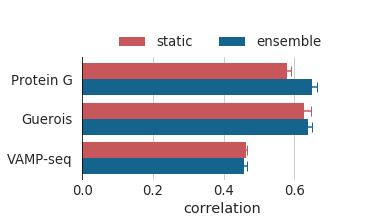

<IPython.core.display.Javascript object>

In [17]:
fig, ax = plt.subplots(figsize=(5,2.25))
g = sns.barplot(data=data, y='data_set', x='correlation', hue='type', ci='std', ax=ax, edgecolor='black',linewidth=0, saturation=saturation)
style_barplot(ax=ax, legend_y=1.0, ncols=2, ticks_above=False)

types = data['type'].unique().tolist()
y_coords = [p.get_y() + 0.5*p.get_height() for p in ax.patches]
x_coords = [p.get_width() for p in ax.patches]
c = [sns.desaturate(sns.color_palette()[types.index(data['type'].to_numpy()[i])], saturation) for i,p in enumerate(ax.patches)]
for i, (x_coord, y_coord) in enumerate(zip(x_coords, y_coords)):
    ax.errorbar(x=x_coord, y=y_coord, xerr=data["std"].to_numpy()[i], c=c[i], fmt="none", capsize=5)

# plt.savefig('figure3.pdf', bbox_inches='tight')
